In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px
#import glob
#import plotly.graph_objects as go
#
from sklearn.preprocessing import MinMaxScaler#, StandardScaler
#from tensorflow.keras.layers import Input, Dense, Activation, Lambda
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.losses import MeanSquaredError, MeanSquaredError
#
#import random
import numpy as np
#from keras import backend as K
#import os
#from contextlib import redirect_stdout
#
import tensorflow as tf
#
#tf.keras.backend.set_floatx('float32')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re

In [14]:
features = 'cycles-exp6-coords4'
num_hidden_nodes = [16, 32]
activations = 2*['tanh']
num_atoms = 40
epoch = 100
train = True

# %%
network = '_'.join([str(x) for x in num_hidden_nodes])
num_hidden_layers = len(num_hidden_nodes)
model_name = features+'--'+network+activations[0]

In [15]:
f_type, n_hops, n_nei = model_name.split('-')[0], *re.findall('\d+', features)

# %%
X_train = pd.read_parquet('X_'+f_type+'_train.parquet')
X_dev = pd.read_parquet('X_'+f_type+'_dev.parquet')
X_test = pd.read_parquet('X_'+f_type+'_test.parquet')
# %%
cols_hops = X_train.columns[X_train.columns.str.startswith(
    tuple(str(x)+'_(' for x in range(int(n_hops)+1)))]
cols_neis = X_train.columns[X_train.columns.str.startswith(
    tuple(str(x)+'_[' for x in range(int(n_nei)+1)))]
cols = cols_hops.to_list()+cols_neis.to_list()+['Atom']
# %%
X_train = X_train.loc[:, cols].copy()
X_dev = X_dev.loc[:, cols].copy()
X_test = X_test.loc[:, cols].copy()

# %%
f_train = pd.read_parquet('y_train.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

f_dev = pd.read_parquet('y_dev.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

f_test = pd.read_parquet('y_test.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

In [16]:
scaler = MinMaxScaler().fit(X_train)

X_test = pd.DataFrame(scaler.transform(
    X_test), columns=X_test.columns, index=X_test.index)
X_dev = pd.DataFrame(scaler.transform(
    X_dev), columns=X_dev.columns, index=X_dev.index)
X_train = pd.DataFrame(scaler.transform(
    X_train), columns=X_train.columns, index=X_train.index)

In [17]:
X_train2 = X_train.to_numpy().reshape(-1, num_atoms, X_train.shape[-1])
X_dev2 = X_dev.to_numpy().reshape(-1, num_atoms, X_dev.shape[-1])
X_test2 = X_test.to_numpy().reshape(-1,  num_atoms, X_test.shape[-1])

In [18]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=0)

In [19]:
model = tf.keras.models.load_model('./results/'+model_name+'/checkpoints', compile = False)#, custom_objects={'loss': my_loss_fn})

In [20]:
predictions = {}
xs2 = [X_train2, X_dev2, X_test2]
ys2 = [f_train, f_dev, f_test]
xs = [X_train, X_dev, X_test]
for i, set in enumerate(['train', 'dev', 'test']):
    xvals = xs2[i]  # .to_numpy().reshape(-1, num_atoms, xs[i].shape[-1])
    y_pred2 = model.predict_on_batch(xvals)
    y_pred = pd.DataFrame(y_pred2.reshape(-1, 3),
                          columns=['x_hat', 'y_hat', 'z_hat'], index=xs[i].index)
    y_real = pd.DataFrame(ys2[i].reshape(-1, 3),
                          columns=['x', 'y', 'z'], index=xs[i].index)
    df_pred = pd.concat([y_real, y_pred], axis=1)
    predictions[set] = df_pred
df_pred = pd.concat(predictions)
df_pred['f'] = np.sqrt((df_pred[['x', 'y', 'z']]**2).sum(axis=1))
df_pred['f_hat'] = np.sqrt((df_pred[['x_hat', 'y_hat', 'z_hat']]**2).sum(axis=1))

In [21]:
mae_train = ((df_pred['f'] - df_pred['f_hat']).abs()).loc['train'].mean()
mae_test = ((df_pred['f'] - df_pred['f_hat']).abs()).loc['test'].mean()
mae_val = ((df_pred['f'] - df_pred['f_hat']).abs()).loc['dev'].mean()

std_mae_train = ((df_pred['f'] - df_pred['f_hat']).abs()).loc['train'].std()
std_mae_test = ((df_pred['f'] - df_pred['f_hat']).abs()).loc['test'].std()
std_mae_val = ((df_pred['f'] - df_pred['f_hat']).abs()).loc['dev'].std()

In [22]:
mse_train = ((df_pred['f'] - df_pred['f_hat'])**2).loc['train'].mean()
mse_test = ((df_pred['f'] - df_pred['f_hat'])**2).loc['test'].mean()
mse_val = ((df_pred['f'] - df_pred['f_hat'])**2).loc['dev'].mean()

std_mse_train = ((df_pred['f'] - df_pred['f_hat'])**2).loc['train'].std()
std_mse_test = ((df_pred['f'] - df_pred['f_hat'])**2).loc['test'].std()
std_mse_val = ((df_pred['f'] - df_pred['f_hat'])**2).loc['dev'].std()

In [23]:
s_mse_test = ('{0:.3f} ± {1:.3f}').format(mse_test, std_mse_test)
s_mse_train = ('{0:.3f} ± {1:.3f}').format(mse_train, std_mse_train)
s_mse_val = ('{0:.3f} ± {1:.3f}').format(mse_val, std_mse_val)



In [24]:
s_mae_test = ('{0:.3f} ± {1:.3f}').format(mae_test, std_mae_test)
s_mae_train = ('{0:.3f} ± {1:.3f}').format(mae_train, std_mae_train)
s_mae_val = ('{0:.3f} ± {1:.3f}').format(mae_val, std_mae_val)


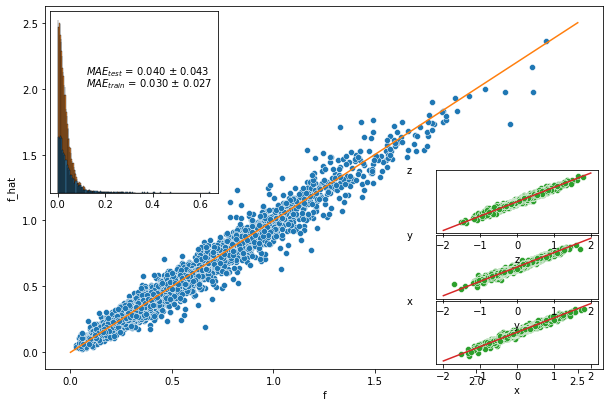

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pal = sns.color_palette()

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10, 6.67))

sns.scatterplot(data =  df_pred.loc['test'], x = 'f', y = 'f_hat', ax = axs)
sns.lineplot(x = [0, 2.5], y =  [0, 2.5], color = pal[1], ax = axs)

axins = inset_axes(axs, width="30%", height="50%", loc=2)
axins2 = inset_axes(axs, width="35%", height="20%", loc=4, bbox_to_anchor=(.17, .0,  .83, .87), bbox_transform=axs.transAxes,)
axins3 = inset_axes(axs, width="35%", height="20%", loc=4, bbox_to_anchor=(.17, .18, .83, .87), bbox_transform=axs.transAxes,)
axins4 = inset_axes(axs, width="35%", height="20%", loc=4, bbox_to_anchor=(.17, .36, .83, .87), bbox_transform=axs.transAxes,)


sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['train'], ax = axins, color = pal[1])
sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'], ax = axins)
sns.histplot(data = df_pred2_sum_atom.loc['test']['mse'], ax = axins2, stat = 'density', kde = True, bins = 10, binrange=(0,200))
sns.histplot(data = df_pred2_sum_atom.loc['train']['mse'], ax = axins2, stat = 'density', kde = True, bins = 10, binrange=(0,200), color = pal[7])

#sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axins2)
#sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axins3)
axins.text(x = 0.12, y = 1000, s = r'$MAE_{test}$ = '+s_mae_test)
axins.text(x = 0.12, y = 900, s = r'$MAE_{train}$ = '+s_mae_train)

t = ['x', 'y', 'z']
#axins.get_xaxis().set_visible(False)
for k, axi in enumerate([axins, axins2, axins3, axins4]):
    #axi.tick_params(labelleft=False, labelbottom=False)
    #axi.get_xaxis().set_visible(False)
    axi.get_yaxis().set_visible(False)
    if k > 0:
        sns.scatterplot(data =  df_pred.loc['test'], x = t[k-1], y = t[k-1]+'_hat', ax = axi, color = pal[2])
        sns.lineplot(x = [-2, 2], y =  [-2, 2], color = pal[3], ax = axi)
        axi.text(x = -3, y = 2, s = t[k-1])

#fig.savefig('analysis-4-model.svg')

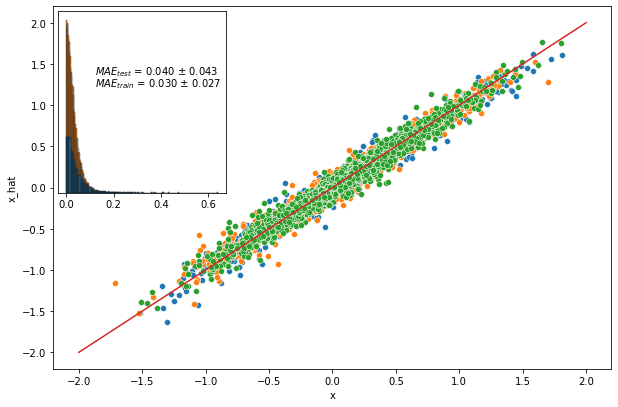

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pal = sns.color_palette()

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10, 6.67))

sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axs, color = pal[0])
sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axs, color = pal[1])
sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = axs, color = pal[2])

sns.lineplot(x = [-2., 2.], y =  [-2, 2.], color = pal[3], ax = axs)

axins = inset_axes(axs, width="30%", height="50%", loc=2)
#axins2 = inset_axes(axs, width="35%", height="20%", loc=4, bbox_to_anchor=(.17, .0,  .83, .87), bbox_transform=axs.transAxes,)
#axins3 = inset_axes(axs, width="35%", height="20%", loc=4, bbox_to_anchor=(.17, .18, .83, .87), bbox_transform=axs.transAxes,)
#axins4 = inset_axes(axs, width="35%", height="20%", loc=4, bbox_to_anchor=(.17, .36, .83, .87), bbox_transform=axs.transAxes,)


sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['train'], ax = axins, color = pal[1])
sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'], ax = axins)

#sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axins2)
#sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axins3)
axins.text(x = 0.12, y = 1000, s = r'$MAE_{test}$ = '+s_mae_test)
axins.text(x = 0.12, y = 900, s = r'$MAE_{train}$ = '+s_mae_train)

t = ['x', 'y', 'z']
#axins.get_xaxis().set_visible(False)
for k, axi in enumerate([axins]):#, axins2, axins3, axins4]):
    #axi.tick_params(labelleft=False, labelbottom=False)
    #axi.get_xaxis().set_visible(False)
    axi.get_yaxis().set_visible(False)
    if k > 0:
        sns.scatterplot(data =  df_pred.loc['test'], x = t[k-1], y = t[k-1]+'_hat', ax = axi, color = pal[2])
        sns.lineplot(x = [-2, 2], y =  [-2, 2], color = pal[3], ax = axi)
        axi.text(x = -3, y = 2, s = t[k-1])

#fig.savefig('analysis-4-model.svg')

In [ ]:
fig = make_subplots(rows = 1, cols = 2)#go.Figure()

scat = go.Scatter(x = df_pred.loc['test']['f'], y =  df_pred.loc['test']['f_hat'], mode='markers')
line = go.Scatter(x = [0, 4.0], y =  [0, 4.0])#, mode='line')
hist_test = go.Histogram(x = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'])#, xbinx=30)
hist_train = go.Histogram(x = (df_pred['f'] - df_pred['f_hat']).abs().loc['train'])#, xbinx=30)
hist_dev = go.Histogram(x = (df_pred['f'] - df_pred['f_hat']).abs().loc['dev'])
fig.add_traces([scat, line, hist_train,hist_dev, hist_test], rows = 1, cols = [1,1,2,2,2])
fig.show()

In [ ]:
fig = make_subplots(rows = 1, cols = 3)#go.Figure()

scat_x = go.Scatter(x = df_pred.loc['test']['x'], y =  df_pred.loc['test']['x_hat'], mode='markers', name = 'x')
scat_y = go.Scatter(x = df_pred.loc['test']['y'], y =  df_pred.loc['test']['y_hat'], mode='markers', name = 'y')
scat_z = go.Scatter(x = df_pred.loc['test']['z'], y =  df_pred.loc['test']['z_hat'], mode='markers', name = 'z')

line = go.Scatter(x = [-3, 3], y =  [-3, 3], name = 'Fit')

fig.add_traces([scat_x, line, scat_y,line, scat_z, line], rows = 1, cols = [1,1,2,2,3,3])
fig.show()

In [ ]:
df_pred[['Atom','Structure']] = df_pred.reset_index()['level_1'].str.split('--').to_list()
df_pred2 = df_pred.reset_index()
df_pred2 = df_pred2.rename(columns={'level_0':'Set', 'level_1':'Full Index'})
df_pred2['Atom Type'] = df_pred2['Atom'].str.split('_').str[0]

In [ ]:
for i in ['x', 'y','z','f']:
    df_pred2['ae_'+i] = (df_pred2[i] - df_pred2[i+'_hat']).abs()
    df_pred2['se_'+i] = (df_pred2[i] - df_pred2[i+'_hat'])**2#.abs()

In [ ]:
df_pred2_sum = df_pred2.groupby(['Set','Structure']).sum()

In [ ]:
fig = make_subplots(rows = 1, cols = 2)#go.Figure()

scat = go.Scatter(x = df_pred2_sum.loc['train']['f'], y =  df_pred2_sum.loc['train']['f_hat'], mode='markers')
line = go.Scatter(x = [10, 45], y =  [10, 45])
hist_test = go.Histogram(x = df_pred2_sum.loc['test']['ae_f'])
hist_train = go.Histogram(x =  df_pred2_sum.loc['train']['ae_f'])
hist_dev = go.Histogram(x =  df_pred2_sum.loc['dev']['ae_f'])
fig.add_traces([scat, line, hist_train,hist_dev, hist_test], rows = 1, cols = [1,1,2,2,2])
fig.show()